# import modules

In [1]:
import pandas as pd
from Bio import SeqIO
from Bio import Entrez
from Bio.Blast import NCBIXML
from Bio.Blast import NCBIWWW
from Bio import ExPASy
import biomart 

# load data

In [2]:
rpvg = "/data/Phillippy/projects/HG002_Masseq/06.pantranscriptome/07.hg002v1.0.1/05.quantification/hg002v101.allGene.isoquantModel.rpvg_joint.txt"

In [3]:
rpvg_tab = pd.read_csv(rpvg, sep="\t")
rpvg_tab.head()

,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2
0,TCONS_00020747_R1,TCONS_00020747_H1,20,1.0,0.000000,0.000000,0.00000,0.000000
1,transcript12583.chr10.nic_R1,transcript12583.chr10.nic_H1,20,1.0,400.482380,50.293997,233.34355,29.312355
2,TCONS_00020735_R1,TCONS_00020735_H1,20,1.0,14.922362,6.534654,0.00000,0.000000
3,TCONS_00020751_R1,TCONS_00020751_H1,20,1.0,0.000000,0.000000,0.00000,0.000000
4,TCONS_00020739_R1,TCONS_00020739_H1,20,1.0,0.000000,0.000000,0.00000,0.000000


In [4]:
rpvg_tab[rpvg_tab['Name_2'] == '.']

,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2
16,transcript1930.chr20.nnic_R1,.,260,1.000000,15.921570,1.134495,0.0,0.0
17,transcript1926.chr20.nnic_R1,.,260,1.000000,0.000000,0.000000,0.0,0.0
18,transcript1946.chr20.nic_R1,.,260,1.000000,0.000000,0.000000,0.0,0.0
19,transcript1964.chr20.nic_R1,.,260,1.000000,0.000000,0.000000,0.0,0.0
20,TCONS_00118332_H1,.,260,1.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
12817,TCONS_00149580_R1,.,1675,0.164640,0.000000,0.000000,0.0,0.0
12820,TCONS_00036484_H1,.,1675,0.082049,0.133396,0.036683,0.0,0.0
12821,TCONS_00036488_H1,.,1675,0.082049,0.112752,0.030996,0.0,0.0
12823,TCONS_00149578_R1,.,1675,0.164640,0.000000,0.000000,0.0,0.0


In [5]:
tarpvg_tabb = rpvg_tab[rpvg_tab['Name_1'] != 'Unknown']
rpvg_tab_unproject = rpvg_tab[rpvg_tab['Name_2'] == '.']
rpvg_tab_unproject.head(3)
rpvg_tab = rpvg_tab[rpvg_tab['Name_2'] != '.']

# Table modification

In [6]:
# make transcript name
rpvg_tab['trans'] = rpvg_tab['Name_1'].str.replace('_R1','',regex=False)
rpvg_tab['trans'] = rpvg_tab['trans'].str.replace('_H1','',regex=True)
rpvg_tab['trans'] = rpvg_tab['trans'].str.replace('_H2','',regex=True)
rpvg_tab.head(2)

,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2,trans
0,TCONS_00020747_R1,TCONS_00020747_H1,20,1.0,0.00000,0.000000,0.00000,0.000000,TCONS_00020747
1,transcript12583.chr10.nic_R1,transcript12583.chr10.nic_H1,20,1.0,400.48238,50.293997,233.34355,29.312355,transcript12583.chr10.nic


In [7]:
trans_gene = pd.read_csv("/data/Phillippy/projects/HG002_Masseq/03.align/HG002_Bulk/01.mapped/chm13_2312_2/gtf/chm13v2.0.refseq_curated5.1.rCRS.chrEBV.combined.transcript-gene.pair",
                        sep='\t', header=None)
trans_gene.columns = ['trans','gene']
trans_gene.head(2)

,trans,gene
0,TCONS_00000001,LOC124905335
1,TCONS_00000002,LINC01409


In [8]:
rpvg_gene = rpvg_tab.merge(trans_gene, left_on="trans", right_on="trans", how = 'left')
rpvg_gene.head(3)

,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2,trans,gene
0,TCONS_00020747_R1,TCONS_00020747_H1,20,1.0,0.000000,0.000000,0.00000,0.000000,TCONS_00020747,WASHC2A
1,transcript12583.chr10.nic_R1,transcript12583.chr10.nic_H1,20,1.0,400.482380,50.293997,233.34355,29.312355,transcript12583.chr10.nic,NaN
2,TCONS_00020735_R1,TCONS_00020735_H1,20,1.0,14.922362,6.534654,0.00000,0.000000,TCONS_00020735,WASHC2A


# Filtering highest probability within each isoform

In [9]:
idx = rpvg_gene.groupby(['trans'])['HaplotypingProbability'].transform(max) == rpvg_gene['HaplotypingProbability']

In [10]:
# select only one transcript with highest HaplotypingProbability
rpvg_gene['max'] = "N"
rpvg_gene.loc[idx,'max'] = "T"
rpvg_gene_max = rpvg_gene[rpvg_gene['max'] == "T"]
# del joint['max']

In [11]:
# remove transcripts that have multiple combinations with same HaplotypingProbability
dup = rpvg_gene_max.loc[rpvg_gene_max.duplicated(subset="trans", keep=False),'trans'].tolist()
rpvg_gene_max = rpvg_gene_max[~rpvg_gene_max.trans.isin(dup)]

In [12]:
rpvg_gene_max.shape

(7013, 11)

In [13]:
rpvg_gene_max.head(3)

,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2,trans,gene,max
0,TCONS_00020747_R1,TCONS_00020747_H1,20,1.0,0.000000,0.000000,0.00000,0.000000,TCONS_00020747,WASHC2A,T
1,transcript12583.chr10.nic_R1,transcript12583.chr10.nic_H1,20,1.0,400.482380,50.293997,233.34355,29.312355,transcript12583.chr10.nic,NaN,T
2,TCONS_00020735_R1,TCONS_00020735_H1,20,1.0,14.922362,6.534654,0.00000,0.000000,TCONS_00020735,WASHC2A,T


In [14]:
rpvg_gene_max.to_csv('/data/Phillippy/projects/HG002_Masseq/06.pantranscriptome/07.hg002v1.0.1/05.quantification/hg002v101.allGene.isoquantModel.rpvg_joint.max.txt',
          sep='\t', index = None)

### Make expression table by haplotypes

In [15]:
hap1 = rpvg_gene_max[['trans',"TPM_1"]]
hap2 = rpvg_gene_max[['trans',"TPM_2"]]
hapExp = hap1.merge(hap2, left_on = "trans", right_on = "trans")
hapExp.columns = ['transcript_id','hap1','hap2']

In [16]:
hapExp

,transcript_id,hap1,hap2
0,TCONS_00020747,0.000000,0.000000
1,transcript12583.chr10.nic,50.293997,29.312355
2,TCONS_00020735,6.534654,0.000000
3,TCONS_00020751,0.000000,0.000000
4,TCONS_00020739,0.000000,0.000000
...,...,...,...
7008,TCONS_00037841,0.000000,0.000000
7009,TCONS_00037838,0.000000,0.000000
7010,TCONS_00037840,0.000000,0.000000
7011,transcript44779.chr11.nic,0.000000,0.000000


In [17]:
hapExp.to_csv('/data/Phillippy/projects/HG002_Masseq/06.pantranscriptome/07.hg002v1.0.1/05.quantification/hg002v101.allGene.isoquantModel.rpvg_joint.max.hap.txt',
          sep='\t', index = None)

# Allele specific expression discovery

In [18]:
rpvg_gene_max["FC"] = rpvg_gene_max[["ReadCount_1", "ReadCount_2"]].max(axis=1) / rpvg_gene_max[["ReadCount_1", "ReadCount_2"]].min(axis=1)
rpvg_gene_max["MAX_value"] = rpvg_gene_max[["ReadCount_1", "ReadCount_2"]].max(axis=1)

# filter the result

In [70]:
rpvg_gene_max_filter = rpvg_gene_max[(rpvg_gene_max['ReadCount_1'] != 0 ) | (rpvg_gene_max['ReadCount_2'] != 0 )]

In [71]:
df = rpvg_gene_max_filter

In [77]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# Create a new column to check if "FC" column has infinity values
df['FC_is_inf'] = np.isinf(df['FC'])

# Define conditions
condition_1 = (df['FC_is_inf']) & (df['MAX_value'] > 10)
condition_2 = (df['FC'] > 2) & (df['MAX_value'] > 10)

# Use boolean indexing to select rows that meet either condition_1 or condition_2
selected_rows = df[condition_1 | condition_2]

# Drop the temporary column created for checking infinity values
selected_rows = selected_rows.drop(columns=['FC_is_inf'])
selected_rows = selected_rows.sort_values(by=['FC', 'MAX_value'], ascending=False)

/tmp/ipykernel_138690/513393006.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FC_is_inf'] = np.isinf(df['FC'])


In [78]:
selected_rows

,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2,trans,gene,max,FC,MAX_value
7634,TCONS_00019335_H1,TCONS_00019335_H2,114,1.0,1427.151300,408.168440,0.000000,0.000000,TCONS_00019335,FBH1,T,inf,1427.151300
4912,TCONS_00022257_H1,TCONS_00022257_H2,12,1.0,1082.466900,372.891020,0.000000,0.000000,TCONS_00022257,LZTS2,T,inf,1082.466900
8331,transcript19906.chr10.nic_H1,transcript19906.chr10.nic_H2,28,1.0,709.998390,172.740280,0.000000,0.000000,transcript19906.chr10.nic,NaN,T,inf,709.998390
4911,TCONS_00022247_H1,TCONS_00022247_H2,12,1.0,0.000000,0.000000,591.636730,208.720580,TCONS_00022247,LZTS2,T,inf,591.636730
3201,TCONS_00020436_H1,TCONS_00020436_H2,65,1.0,558.579400,118.216390,0.000000,0.000000,TCONS_00020436,WASHC2C,T,inf,558.579400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3571,transcript6166.chr9.nnic_H1,transcript6166.chr9.nnic_H2,310,1.0,84.807390,7.034318,41.859096,3.800299,transcript6166.chr9.nnic,NaN,T,2.026021,84.807390
2893,TCONS_00020768_H1,TCONS_00020768_H2,138,1.0,72.399289,13.411878,36.078672,6.691859,TCONS_00020768,ASAH2B,T,2.006706,72.399289
7168,TCONS_00019949_R1,TCONS_00019949_H1,443,1.0,44.712496,28.115304,22.287304,14.004438,TCONS_00019949,BAMBI,T,2.006187,44.712496
8463,TCONS_00023461_H1,TCONS_00023461_H2,462,1.0,20.967747,7.453056,42.032253,14.940507,TCONS_00023461,ASB13,T,2.004615,42.032253


In [80]:
selected_rows.to_csv('/data/Phillippy/projects/HG002_Masseq/06.pantranscriptome/07.hg002v1.0.1/05.quantification/FC.maxVlaue.txt',
          sep='\t', index = None)

## Methylation match

In [83]:
selectFile="/data/Phillippy/projects/HG002_Masseq/06.pantranscriptome/07.hg002v1.0.1/05.quantification/FC.maxVlaue.txt"
gtfFile="/data/Phillippy/projects/HG002_Masseq/06.pantranscriptome/07.hg002v1.0.1/00.references/chm13.hg002_read.isoquantModel.squanti3_rescued.gtf"

## Intersect Known allele speccific expression

In [22]:
# alleleSpecific = pd.read_csv("/data/Phillippy/projects/HG002_Masseq/06.pantranscriptome/06.1kg_EURnonCEU/allelicInbalnce.trans.csv")
# alleleSpecific = pd.read_csv("/data/Phillippy/projects/HG002_Masseq/06.pantranscriptome/06.1kg_EURnonCEU/allelespecificGene.list")
alleleSpecific = pd.read_csv("/data/Phillippy/projects/HG002_Masseq/06.pantranscriptome/06.1kg_EURnonCEU/geneImprint.list")
alleleSpecific['state'] = 'allelespecific'
alleleSpecific.head(3)

,gene,state
0,NDUFA4P1,allelespecific
1,GFI1,allelespecific
2,DIRAS3,allelespecific


In [23]:
alleleSpecific.shape

(275, 2)

In [24]:
joint_rpvg_knownASE = rpvg_gene_max_filter.merge(alleleSpecific, left_on="gene", right_on="gene", how = 'left')
joint_rpvg_knownASE.head(3)

,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2,trans,gene,max,FC,MAX_value,state
0,transcript12583.chr10.nic_R1,transcript12583.chr10.nic_H1,20,1.0,400.482380,50.293997,233.34355,29.312355,transcript12583.chr10.nic,NaN,T,1.716278,400.482380,NaN
1,TCONS_00020735_R1,TCONS_00020735_H1,20,1.0,14.922362,6.534654,0.00000,0.000000,TCONS_00020735,WASHC2A,T,inf,14.922362,NaN
2,TCONS_00020748_R1,TCONS_00020748_H1,20,1.0,4.643587,0.997655,84.08753,18.065849,TCONS_00020748,WASHC2A,T,18.108315,84.087530,NaN


In [25]:
joint_rpvg_knownASE[~joint_rpvg_knownASE['state'].isna()]

,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2,trans,gene,max,FC,MAX_value,state
67,TCONS_00175647_R1,TCONS_00175647_R1,1397,0.720283,0.844897,3.279558,0.844897,3.279558,TCONS_00175647,FASTK,T,1.000000,0.844897,allelespecific
969,TCONS_00023278_R1,TCONS_00023278_H1,155,1.000000,422.470910,241.810110,442.851260,253.475230,TCONS_00023278,PAOX,T,1.048241,442.851260,allelespecific
970,TCONS_00023283_R1,TCONS_00023283_H1,155,1.000000,153.184910,166.803150,170.897510,186.090410,TCONS_00023283,PAOX,T,1.115629,170.897510,allelespecific
971,TCONS_00023281_R1,TCONS_00023281_H1,155,1.000000,64.398497,43.994902,69.595190,47.545109,TCONS_00023281,PAOX,T,1.080696,69.595190,allelespecific
972,TCONS_00023279_R1,TCONS_00023279_H1,155,1.000000,0.000000,0.000000,44.006452,34.197827,TCONS_00023279,PAOX,T,inf,44.006452,allelespecific
973,TCONS_00023280_R1,TCONS_00023280_H1,155,1.000000,0.000000,0.000000,16.536629,10.531766,TCONS_00023280,PAOX,T,inf,16.536629,allelespecific
1134,TCONS_00026443_H2,TCONS_00026443_H2,187,0.995278,1617.899200,511.913680,1617.899200,511.913680,TCONS_00026443,LDB1,T,1.000000,1617.899200,allelespecific
1135,TCONS_00026444_H2,TCONS_00026444_H2,187,0.995278,1020.078900,323.447220,1020.078900,323.447220,TCONS_00026444,LDB1,T,1.000000,1020.078900,allelespecific
1480,TCONS_00109160_H1,TCONS_00109160_H1,2045,1.000000,0.500000,0.202471,0.500000,0.202471,TCONS_00109160,CYP1B1,T,1.000000,0.500000,allelespecific
2103,TCONS_00125624_H2,TCONS_00125624_H2,1511,0.724249,2.896886,1.123643,2.896886,1.123643,TCONS_00125624,DGCR6L,T,1.000000,2.896886,allelespecific


## Plot

In [89]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
%matplotlib notebook
%matplotlib widget
%matplotlib inline

In [690]:
gene_to_plt = "LZTS2"

In [691]:
by_transcript = rpvg_gene_max[rpvg_gene_max['gene'] == gene_to_plt]
by_transcript.index = by_transcript.trans
by_transcript.head()

,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2,trans,gene,max,FC,MAX_value
trans,,,,,,,,,,,,,
TCONS_00022252,TCONS_00022252_H1,TCONS_00022252_H2,12,1.0,0.00000,0.00000,86.880079,30.079537,TCONS_00022252,LZTS2,T,inf,86.880079
TCONS_00022253,TCONS_00022253_H1,TCONS_00022253_H2,12,1.0,0.00000,0.00000,14.977581,6.968976,TCONS_00022253,LZTS2,T,inf,14.977581
TCONS_00022248,TCONS_00022248_H1,TCONS_00022248_H2,12,1.0,185.44009,84.86891,231.937840,106.149170,TCONS_00022248,LZTS2,T,1.250743,231.937840
TCONS_00022255,TCONS_00022255_H1,TCONS_00022255_H2,12,1.0,0.00000,0.00000,63.515362,20.652876,TCONS_00022255,LZTS2,T,inf,63.515362
TCONS_00022251,TCONS_00022251_H1,TCONS_00022251_H2,12,1.0,540.11606,184.70664,635.982260,217.490560,TCONS_00022251,LZTS2,T,1.177492,635.982260


In [692]:
list(by_transcript.index)

['TCONS_00022252',
 'TCONS_00022253',
 'TCONS_00022248',
 'TCONS_00022255',
 'TCONS_00022251',
 'TCONS_00022250',
 'TCONS_00022247',
 'TCONS_00022257']

In [693]:
by_transcript['log_totalExp']  = np.log10(by_transcript['TPM_1'] + by_transcript['TPM_2']+1)
by_transcript = by_transcript.sort_values(by = "log_totalExp", ascending=True)
by_transcript_totalExp = by_transcript[['log_totalExp']]
by_transcript_totalExp.index = by_transcript['trans']
by_transcript_totalExp.head()

/tmp/ipykernel_138690/1219754040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  by_transcript['log_totalExp']  = np.log10(by_transcript['TPM_1'] + by_transcript['TPM_2']+1)


,log_totalExp
trans,
TCONS_00022250,0.000000
TCONS_00022253,0.901403
TCONS_00022255,1.335516
TCONS_00022252,1.492475
TCONS_00022248,2.283342


In [694]:
totalMAX=max(by_transcript_totalExp['log_totalExp'])+0.1

In [695]:
by_transcript['ReadCount_1_prob']  = by_transcript['ReadCount_1'] / (by_transcript['ReadCount_1'] + by_transcript['ReadCount_2'] ) * 100
by_transcript['ReadCount_2_prob']  = by_transcript['ReadCount_2'] / (by_transcript['ReadCount_1'] + by_transcript['ReadCount_2'] ) * 100
by_transcript_prob = by_transcript[['ReadCount_1_prob','ReadCount_2_prob']]

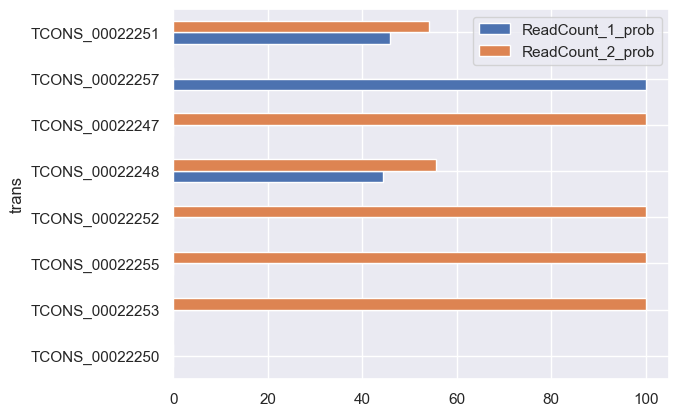

In [696]:
ax1 = by_transcript_prob.plot.barh()

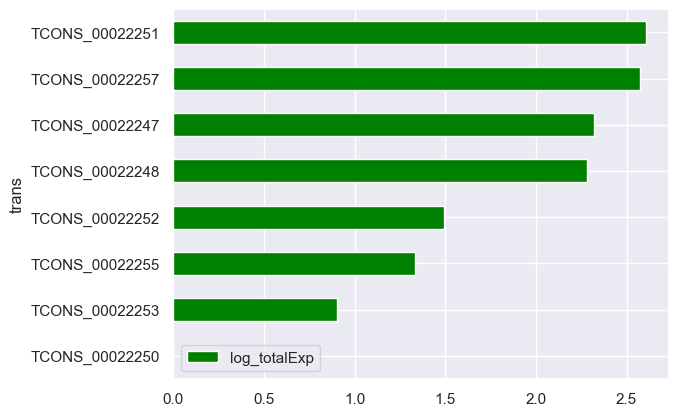

In [697]:
ax2 = by_transcript_totalExp.plot.barh(color="green")

In [698]:
by_transcript_prob

,ReadCount_1_prob,ReadCount_2_prob
trans,,
TCONS_00022250,NaN,NaN
TCONS_00022253,0.000000,100.000000
TCONS_00022255,0.000000,100.000000
TCONS_00022252,0.000000,100.000000
TCONS_00022248,44.429779,55.570221
TCONS_00022247,0.000000,100.000000
TCONS_00022257,100.000000,0.000000
TCONS_00022251,45.924397,54.075603


In [699]:
import numpy as np
by_transcript_FC = pd.DataFrame(np.log10( (by_transcript_prob['ReadCount_1_prob'] + 1) / (by_transcript_prob['ReadCount_2_prob'] + 1)))
by_transcript_FC.columns = ['logFC']
by_transcript_FC = by_transcript_FC.reset_index()
by_transcript_FC['logFC'] = by_transcript_FC['logFC'].fillna(0)
by_transcript_FC.head(6)

,trans,logFC
0,TCONS_00022250,0.000000
1,TCONS_00022253,-2.004321
2,TCONS_00022255,-2.004321
3,TCONS_00022252,-2.004321
4,TCONS_00022248,-0.095247
5,TCONS_00022247,-2.004321


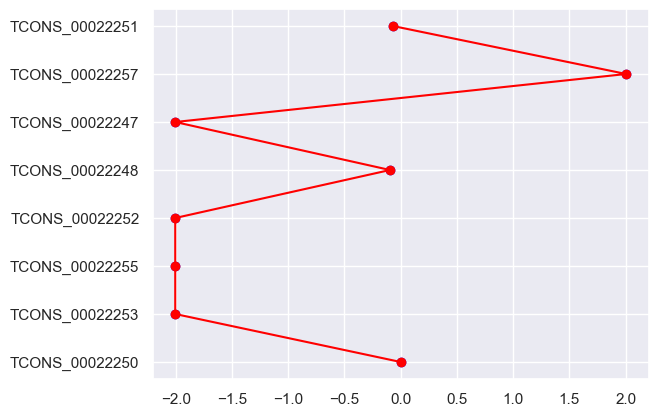

In [700]:
# Plotting
plt.scatter(by_transcript_FC['logFC'], by_transcript_FC['trans'], label='Data points', color='blue')
plt.plot(by_transcript_FC['logFC'], by_transcript_FC['trans'], label='Connected line', color='red', linestyle='-', marker='o')

In [701]:
by_transcript_FC['logFC']

0    0.000000
1   -2.004321
2   -2.004321
3   -2.004321
4   -0.095247
5   -2.004321
6    2.004321
7   -0.069561
Name: logFC, dtype: float64

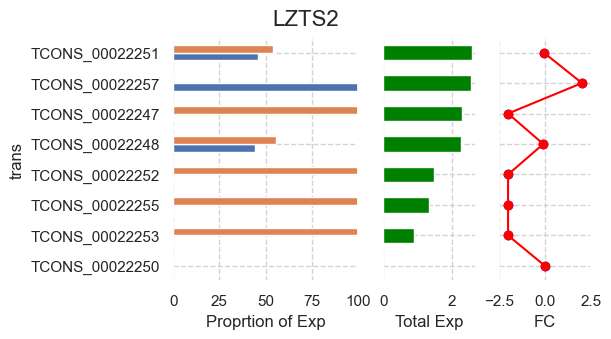

In [702]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a gridspec with one row and three columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(6, 3), frameon=False, constrained_layout=True, gridspec_kw={'width_ratios': [2, 1, 1]})

# Plot data on each subplot
by_transcript_prob.plot.barh(ax=ax1)
by_transcript_totalExp.plot.barh(ax=ax2, color = "green")

ax3.scatter(by_transcript_FC['logFC'], by_transcript_FC['trans'], label='Data points', color='blue')
ax3.plot(by_transcript_FC['logFC'], by_transcript_FC['trans'], label='Connected line', color='red', linestyle='-', marker='o')

# Set x-axis limits for each subplot
ax1.set_xlim(0, 100)
ax2.set_xlim(0, totalMAX)
ax3.set_xlim(-max(abs(by_transcript_FC['logFC']))-0.5, max(abs(by_transcript_FC['logFC']))+0.5)

# Set the background color of each subplot to white
ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax3.set_facecolor('white')

# Set the background color of the figure to white
fig.set_facecolor('white')

# Set the grid color to light gray
ax1.grid(color='lightgray', linestyle='--')
ax2.grid(color='lightgray', linestyle='--')
ax3.grid(color='lightgray', linestyle='--')

# Add x-axis for each subplot
ax1.set_xlabel('Proprtion of Exp')
ax2.set_xlabel('Total Exp')
ax3.set_xlabel('FC')
ax3.set_ylabel('Transcripts')

fig.suptitle(gene_to_plt, fontsize=16, y=1.08)

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
ax3.legend().set_visible(False)


plt.show()


In [689]:
transName="/gpfs/gsfs11/users/kimj75/00.Files/references/hg002/hg002v101/fiberseq/geneTrans.name"
transName = pd.read_csv(transName, sep='\t', header=None)
transName.columns = ['trans','gene']
transName.head(7)

,trans,gene
0,TCONS_00000001,LOC124905335
1,TCONS_00000002,LINC01409
2,TCONS_00000003,LINC01409
3,TCONS_00000004,LOC124903817
4,TCONS_00000005,FAM87B
5,TCONS_00000006,LINC01128
6,TCONS_00000010,LINC01128


In [524]:
methyl_hst="/gpfs/gsfs11/users/kimj75/00.Files/references/hg002/hg002v101/fiberseq/FDR-wide-peaks.matToCHM13.hst.bed"
methyl_hst = pd.read_csv(methyl_hst, sep='\t', header=None)
methyl_hst.columns = ['CHM13_chr','CHM13_start','CHM13_End',
                     'trans','Gene1','CHM13_chr_ori','CHM13_start_ori','CHM13_End_ori',
                     'MAT']
methyl_hst.head(3)

,CHM13_chr,CHM13_start,CHM13_End,trans,Gene1,CHM13_chr_ori,CHM13_start_ori,CHM13_End_ori,MAT
0,chr1,154998370,155023314,transcript62227.chr1.nnic,XLOC_001499,chr1,154999432,154999607,chr1_MATERNAL:150697855-150698030
1,chr1,160132277,160158230,TCONS_00014993,XLOC_003870,chr1,160134481,160134651,chr1_MATERNAL:155830323-155830493
2,chr1,205949085,205998488,TCONS_00007762,XLOC_001993,chr1,205967984,205968201,chr1_MATERNAL:201600559-201600776


In [509]:
tab = methyl_hst.merge(transName, on = "trans")
tab= tab[['MAT','gene']]
tab.head(3)


,MAT,gene
0,chr1_MATERNAL:155830323-155830493,F11R
1,chr1_MATERNAL:201600559-201600776,MAPKAPK2
2,chr1_MATERNAL:201614101-201614324,MAPKAPK2


In [238]:
selected_rows.head(3)

,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2,trans,gene,max,FC,MAX_value
7634,TCONS_00019335_H1,TCONS_00019335_H2,114,1.0,1427.15130,408.16844,0.0,0.0,TCONS_00019335,FBH1,T,inf,1427.15130
4912,TCONS_00022257_H1,TCONS_00022257_H2,12,1.0,1082.46690,372.89102,0.0,0.0,TCONS_00022257,LZTS2,T,inf,1082.46690
8331,transcript19906.chr10.nic_H1,transcript19906.chr10.nic_H2,28,1.0,709.99839,172.74028,0.0,0.0,transcript19906.chr10.nic,NaN,T,inf,709.99839


In [242]:
selected_rows_wGene = tab.merge(selected_rows, on="gene", how="right")
selected_rows_wGene.head(3)

,MAT,gene,Name_1,Name_2,ClusterID,HaplotypingProbability,ReadCount_1,TPM_1,ReadCount_2,TPM_2,trans,max,FC,MAX_value
0,chr10_MATERNAL:5895266-5895422,FBH1,TCONS_00019335_H1,TCONS_00019335_H2,114,1.0,1427.1513,408.16844,0.0,0.0,TCONS_00019335,T,inf,1427.1513
1,chr10_MATERNAL:5895266-5895422,FBH1,TCONS_00019335_H1,TCONS_00019335_H2,114,1.0,1427.1513,408.16844,0.0,0.0,TCONS_00019335,T,inf,1427.1513
2,chr10_MATERNAL:5895266-5895422,FBH1,TCONS_00019335_H1,TCONS_00019335_H2,114,1.0,1427.1513,408.16844,0.0,0.0,TCONS_00019335,T,inf,1427.1513


In [258]:
from io import StringIO
selected_rows_wGene = selected_rows_wGene[selected_rows_wGene['MAT'].notna()]
selected_rows_wGene.groupby('gene')['MAT'].apply(lambda x: ','.join(x)).reset_index()

,gene,MAT
0,ADK,"chr10_MATERNAL:76276354-76276516,chr10_MATERNA..."
1,ASB13,chr10_MATERNAL:5656621-5656899
2,ASCC1,"chr10_MATERNAL:74105754-74105877,chr10_MATERNA..."
3,CERS6,chr2_MATERNAL:168374687-168374917
4,CHST15,"chr10_MATERNAL:126072675-126072827,chr10_MATER..."
5,DDX11-AS1,chr12_MATERNAL:30928100-30928268
6,DNAJB12,"chr10_MATERNAL:74307702-74307858,chr10_MATERNA..."
7,ESYT2,"chr7_MATERNAL:160375686-160375902,chr7_MATERNA..."
8,F11R,chr1_MATERNAL:155830323-155830493
9,FAM167A,"chr8_MATERNAL:11013234-11013463,chr8_MATERNAL:..."
